In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import *
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [2]:
from pathlib import Path
PATH = Path("")
data_path = PATH.home()/'data/Target/data/'
model_path = PATH.home()/'data/Target/models/group10'
recipe_path = data_path/"layer1.json"
recipe_image_path = data_path/"layer2.json"
op_file_path = data_path/"ing_density.csv"

# Load recipes
with open(recipe_path) as json_data:
    recipe = json.load(json_data)

In [3]:
# Load recipe images
with open(recipe_image_path) as json_data:
    recipe_images = json.load(json_data)

In [4]:
# Get grocery product hierarchy information
group10 = pd.read_csv(data_path/'group10_header.csv',
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(data_path/'products.csv')

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

# Fill NAs
group10 = fillNa(group10)

In [5]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
    return stored_data
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df


In [6]:
k=3

# Bi Encoder
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# Cross encoder 
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)

In [7]:
# Classification models
pm = Mapper(group10)
clf_name_class_name = model_path/'nli-classification-class_name'
clf_name_item_type_name = model_path/'nli-classification-item_type_name'
clf_name_subclass_name = model_path/'nli-classification-subclass_name'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.98)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [8]:
multi_lm_embeddings = get_embeddings(data_path/'hier_embeddings.pkl')

In [9]:
filtered_products = list(group10[~pd.isnull(group10['image'])]['tcin'].values)

# Bi encoder without classifier
multi_lm = TransformerRanker(model=multi_lm_embedder, max_rank=k, 
                            filtered_products=filtered_products)
multi_lm.load_embeddings(multi_lm_embeddings)

# Bi encoder with classifier
multi_lm_clf = TransformerRanker(model=multi_lm_embedder,
                                max_rank=k, clf=[clf_class_name, 
                                                clf_item_type_name,
                                                clf_subclass_name],
                                filtered_products=filtered_products)
multi_lm_clf.load_embeddings(multi_lm_embeddings)

# Cross encoder with classifier
cr_multi_lm_clf = CrossEncoderRanker(bi_model=multi_lm_clf, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(data_path/'hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)  

# Cross encoder without classifier
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(data_path/'hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)  

In [10]:
# Load BM25 (For ingredients)
bm25 = joblib.load(model_path/'bm25_no_description')

In [11]:
rc = RankerCombination([bm25, multi_lm_clf], [0.4, 0.6], max_rank=10)
l2_ranker = RankerPipeline([rc, cr_multi_lm], [10, k])

In [12]:
# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values
pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [13]:
# Get random recipe from the 1M recipe corpus
i = random.randint(0, 1000000)
i=315062
print(i)
id, dict_ingredients= recipe_load_index(i, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)

qty = Qty_normal_map(op_file_path= op_file_path, data=group10)

#normalise units
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = qty.combine_qty(df_combined_ing)

#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


315062
Recipe: Teriyaki Marinade


/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/qty_mapping.py:77: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [14]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,fresh gingerroot,tbsp,1.0,15.0,"(1.0, 100.0, cup)",1.0,100.0,cup
1,garlic,cloves,2.0,0.0,"(1.0, 2.0, teaspoon)",1.0,2.0,teaspoon
2,mirin,cup,14.0,3150.0,"(1.0, 244.0, cup)",1.0,244.0,cup
3,salad oil,cup,14.0,3150.0,"(1.0, 100.0, cup)",1.0,100.0,cup
4,soy sauce,cup,12.0,2700.0,"(1.0, 100.0, cup)",1.0,100.0,cup
5,sugar,cup,14.0,3150.0,"(1.0, 100.0, cup)",1.0,100.0,cup


In [15]:
recipe[i]

{'ingredients': [{'text': '12 cup soy sauce'},
  {'text': '14 cup sugar'},
  {'text': '14 cup mirin or 14 cup dry sherry'},
  {'text': '14 cup salad oil'},
  {'text': '1 tablespoon fresh gingerroot'},
  {'text': '2 cloves garlic'}],
 'url': 'http://www.food.com/recipe/teriyaki-marinade-12689',
 'partition': 'train',
 'title': 'Teriyaki Marinade',
 'id': '4e4cfe10fe',
 'instructions': [{'text': 'Combine all ingredients in a blender and blend until smooth.'},
  {'text': 'Pour over desired meat in a large zip lock bag and marinate preferably overnight, but at least 3 or 4 hours.'},
  {'text': 'Makes enough for 2-3 pounds of meat.'}]}

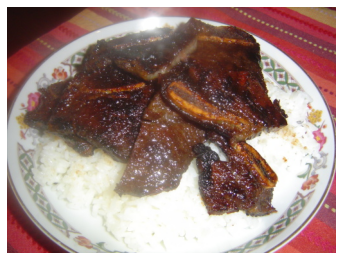

In [16]:
import matplotlib.pyplot as plt
urls = []
for recipe_image in recipe_images:
    if recipe_image['id'] == id:
        for image in recipe_image['images']:
            urls.append(image['url'])
images = pm.get_images_urls(urls)

plt.figure(figsize=(20,10))
columns = 3
for i in range(len(images)):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.axis('off')
    # plt.title(titles[i])
    plt.imshow(images[i])

In [17]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients)

#matching target database with recipe 
join_df = qty.match_ranked_ingredients(k, ranked_match , final_df, recipe_ingredients)

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price']).copy()
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']].copy()

/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/ranker.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()


Filtered salad oil oil for class_name: SHORTENING/OIL
Filtered soy sauce for class_name: ASIAN


fresh gingerroot
[77587103 13460601 77616562]


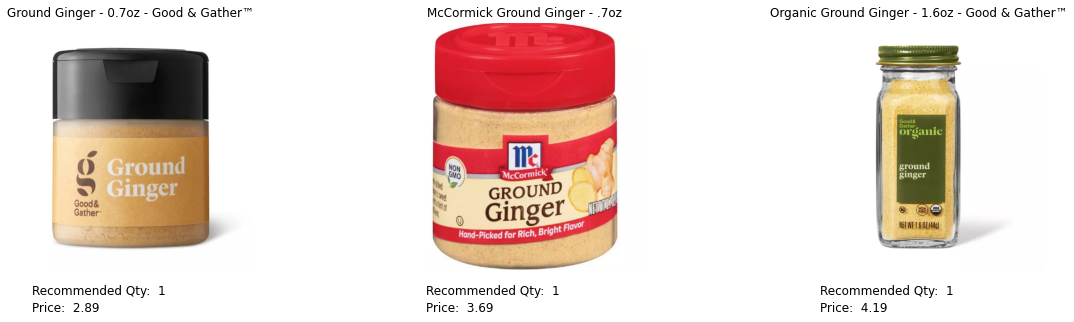

garlic
[14917452 15416581 13556562]


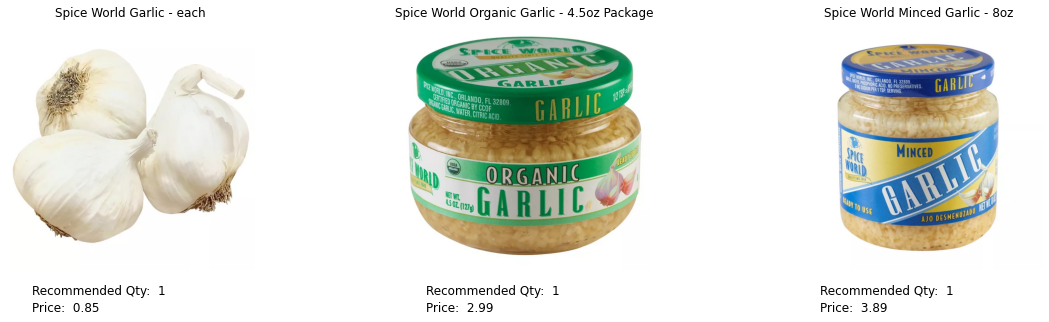

mirin
[52412051 13473434 13460041]


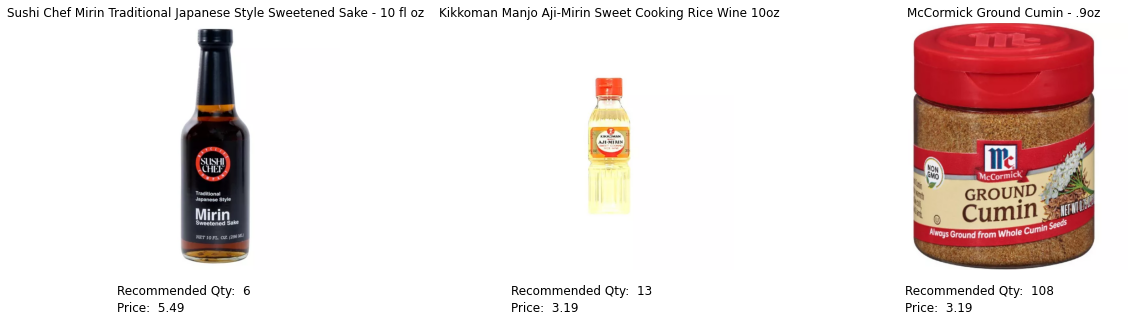

salad oil
[77600243 77600247 77600244]


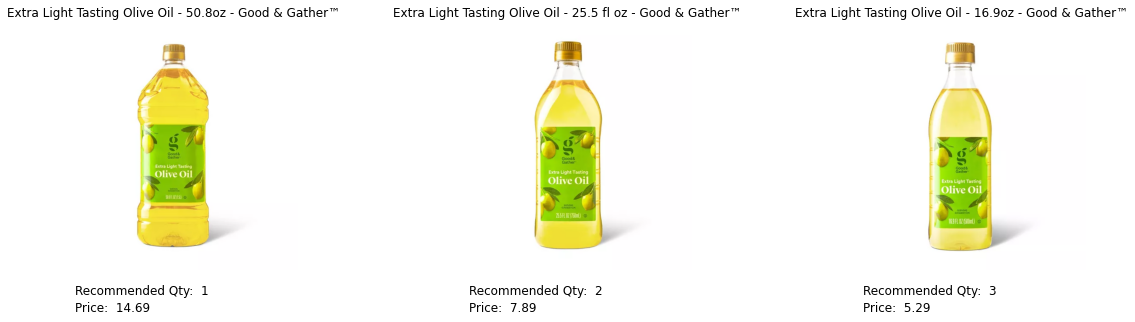

soy sauce
[76758611 47089609 47089314]


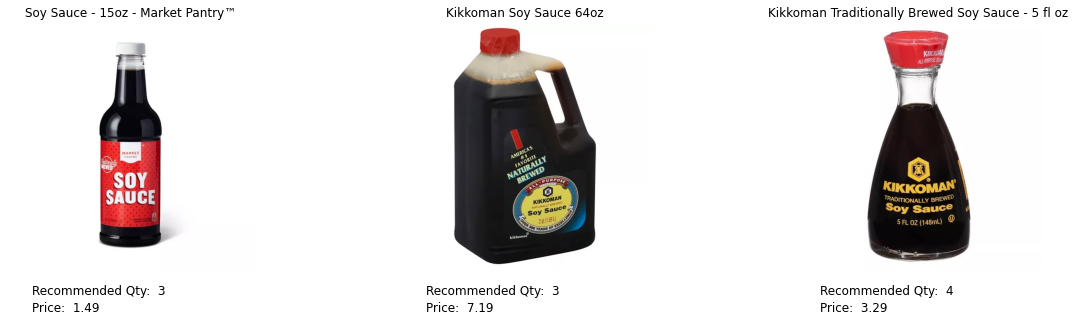

sugar
[16772711 13335745 53432107]


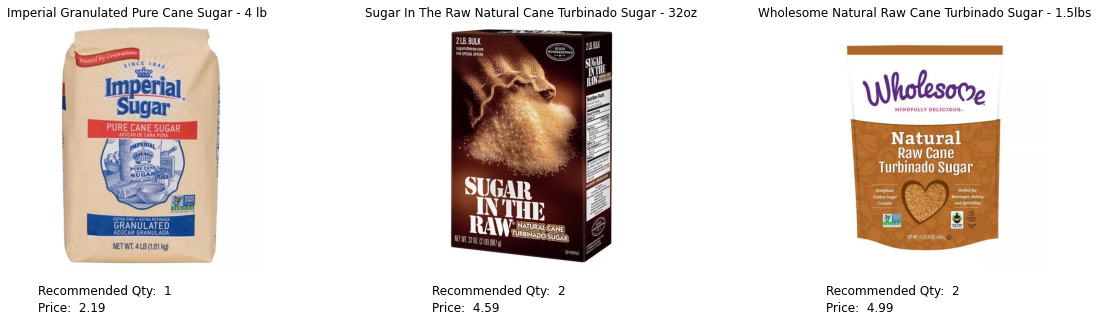

In [18]:
dp.display_products_df(display_df, 3)

Filtered unsalted butter butter for class_name: BUTTER
[80796340, 54534326, 54446566, 13227053, 14729229, 14729228, 14729227, 49110709, 80796339, 13422552]


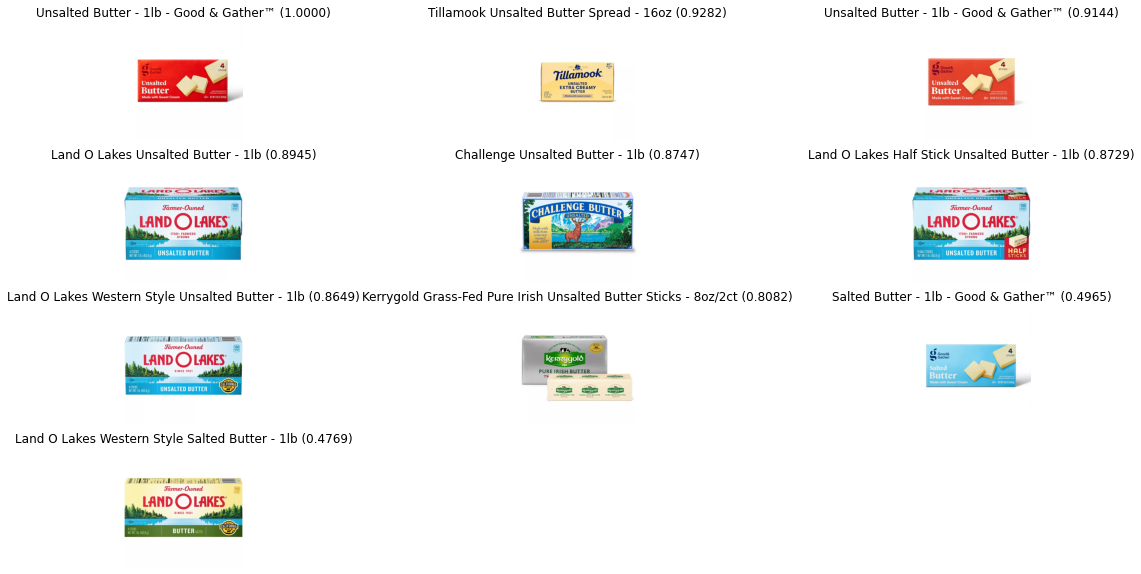

In [19]:
product_scores = rc.get_scores_ingredient('unsalted butter')
dp.display_products_ingredient_score(product_scores)

In [20]:
#fine

#4567
#7609
#32659
#4623
#17864
#7124
#87364

# Both
# 82314
# 24513

In [21]:
# problems

# 83468 - only first matches correct
# 83642 - no dairy free
# 7362 - sliced pepporoni
# 21312 - 